In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import norm
from scipy.signal import find_peaks
from scipy import signal

# Data Loading
This code goes through each folder in 'Back_EMF_Data_Drill' and extracts all the csvs into a big dictionary 'dataframes'. The name and size of all of these entries are printed, ensure that all data is found before proceeding.

In [3]:
# Directory containing the CSV files
repo_path = 'Back_EMF_Data_Drill'

# Dictionary to store DataFrames
dataframes = {}

for foldername in os.listdir(repo_path):
    folder_path = os.path.join(repo_path, foldername)
# Loop through all files in the directory
    for filename in os.listdir(folder_path):
        if filename.endswith('.CSV'):
            # Read the CSV file and skip the header row
            file_path = os.path.join(folder_path, filename)
            df_name = os.path.splitext(filename)[0]
            df = pd.read_csv(file_path, usecols=[3,4], header=None)
            times = df[3]
            times = [time_point+abs(times[0]) for time_point in times]
            voltages = df[4]
            # Store the lists in the dictionary
            dataframes[foldername+df_name] = {'times': list(times), 'voltages': list(voltages)}

for experiment in dataframes:
    print(f"{experiment} has {len(dataframes[experiment]['times'])} data points")


ALL0001_CH1YellowCH2RedF0001CH1 has 2500 data points
ALL0001_CH1YellowCH2RedF0001CH2 has 2500 data points
ALL0002_CH1YellowCH2RedF0002CH1 has 2500 data points
ALL0002_CH1YellowCH2RedF0002CH2 has 2500 data points
ALL0003_CH1YellowCH2RedF0003CH1 has 2500 data points
ALL0003_CH1YellowCH2RedF0003CH2 has 2500 data points
ALL0004_CH1YellowCH2RedF0004CH1 has 2500 data points
ALL0004_CH1YellowCH2RedF0004CH2 has 2500 data points
ALL0005_CH1YellowCH2RedF0005CH1 has 2500 data points
ALL0005_CH1YellowCH2RedF0005CH2 has 2500 data points
BLL0000_CH1YellowCH2BlueF0000CH1 has 2500 data points
BLL0000_CH1YellowCH2BlueF0000CH2 has 2500 data points
BLL0001_CH1YellowCH2BlueF0001CH1 has 2500 data points
BLL0001_CH1YellowCH2BlueF0001CH2 has 2500 data points
BLL0002_CH1YellowCH2BlueF0002CH1 has 2500 data points
BLL0002_CH1YellowCH2BlueF0002CH2 has 2500 data points
BLL0003_CH1YellowCH2BlueF0003CH1 has 2500 data points
BLL0003_CH1YellowCH2BlueF0003CH2 has 2500 data points
BLL0004_CH1YellowCH2BlueF0004CH1 has 2

In [4]:
def nice_plot_please(x, y, title, x_label, y_label):
    plt.figure(figsize=(5, 3))
    plt.plot(x, y,label="Voltage")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)

def nice_plot_please_two(x1, y1, x2, y2, title, x_label, y_label,data_name1,data_name2):
    plt.figure(figsize=(5, 3))
    plt.plot(x1, y1,label=data_name1)
    plt.plot(x2, y2,label=data_name2)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)

# Centering Data
Here each experiment is shifted up and down to centre around 0 and a dictionary "centred_data" is generated containing this..

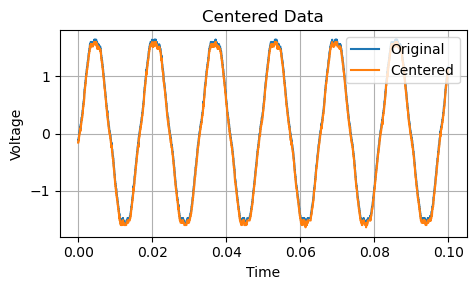

In [5]:
#dictionary of experiments, indexes as [value][0], 0 is time, 1 is voltage
example='ALL0005_CH1YellowCH2RedF0005CH2'

#centering data about 0
centered_data = {}
for experiment in dataframes:
    mean = np.mean(dataframes[experiment]['voltages'])
    centered_data[experiment]= {'times': dataframes[experiment]['times'], 'voltages' : [v - mean for v in dataframes[experiment]['voltages']]}

#dictionary of experiments, indexes as [value][0], 0 is time, 1 is voltage
nice_plot_please_two(dataframes[example]['times'],dataframes[example]['voltages'],centered_data[example]['times'],centered_data[example]['voltages'],"Centered Data","Time","Voltage","Original","Centered")


In [6]:
def back_emf_finder(experiment,data=centered_data,window_start=0,window_size=0,voltage_threshold=1,plot=False,filter=False):
    test_data= data[experiment].copy()

    if filter == True:
        # Compute the Fourier Transform of the voltages
        N = len(test_data['voltages'])
        T = (test_data['times'][100] - test_data['times'][0]/100)  # Sample spacing
        time_step = T

        yf = fft(test_data['voltages'])
        xf = fftfreq(N, T)[:N//2]

        # Compute the power spectrum
        power = 2.0/N * np.abs(yf[:N//2])

        # Find the peaks in the power spectrum
        peaks, _ = find_peaks(power, height=0.1)

        #bandpass filter
        sos = signal.butter(2, 5*xf[peaks][0], 'low', fs=1/time_step, output='sos')
        filtered = signal.sosfilt(sos, test_data['voltages'])
        test_data['voltages'] = filtered
        
    if window_size==0:
        window_size = len(test_data['times'])
    voltage_threshold=1

    # Adjust the distance and prominence parameters to widen the tolerance for peak detection
    peaks_positive, _ = find_peaks(test_data['voltages'][window_start:window_start+window_size], height=voltage_threshold, prominence=0.1, distance=100)
    peaks_negative, _ = find_peaks(-np.array(test_data['voltages'][window_start:window_start+window_size]), height=voltage_threshold, prominence=0.1, distance=100)
    peaks = np.concatenate((peaks_positive, peaks_negative))
    peaks=np.sort(peaks)
    peaks = peaks+window_start

    # Calculate the distance between consecutive peaks in time and voltage and calculate constant
    peak_distances = []
    peak_pairs = []
    back_emf = []
    for i in range(0, len(peaks) - 1, 2):
        time_distance = test_data['times'][peaks[i+1]] - test_data['times'][peaks[i]]
        if time_distance>0.02:
            continue
        peak_pairs.append((peaks[i], peaks[i+1]))
        voltage_distance = test_data['voltages'][peaks[i+1]] - test_data['voltages'][peaks[i]]
        peak_distances.append((time_distance, voltage_distance))
        back_emf.append((1/np.sqrt(3))*abs(voltage_distance*time_distance))

    # # Print the distances
    # for i, (time_dist, volt_dist) in enumerate(peak_distances):
    #     print(f"Peak pair {i+1}: Time distance = {time_dist}, Voltage distance = {volt_dist}")
    #     print(f"Constant = {((1/np.sqrt(3))*abs(volt_dist*time_dist))}")

    if plot == True:
        plt.figure(figsize=(5, 3))
        plt.plot(test_data['times'][window_start:window_start+window_size], test_data['voltages'][window_start:window_start+window_size], label="Voltage")
        for i, (pair) in enumerate(peak_pairs):
            plt.plot([test_data['times'][pair[0]], test_data['times'][pair[1]]], [test_data['voltages'][pair[0]], test_data['voltages'][pair[1]]], "x")
        plt.title("Voltage Peaks")
        plt.xlabel("Time")
        plt.ylabel("Voltage")
        plt.grid(True)
        plt.tight_layout()
        plt.show(block=False)

    return back_emf

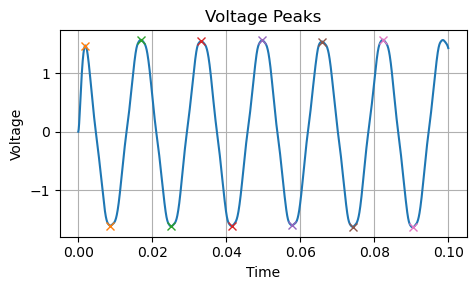

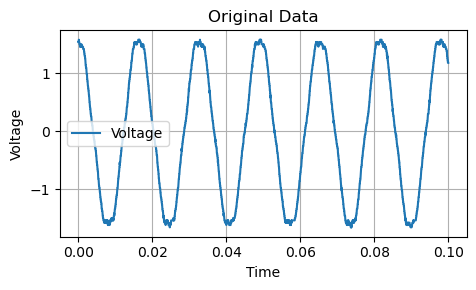

In [10]:
example = "ALL0003_CH1YellowCH2RedF0003CH2"
back_emf = back_emf_finder(example,plot=True,filter=True)
nice_plot_please(centered_data[example]["times"],centered_data[example]["voltages"],"Original Data", "Time", "Voltage")

In [23]:
all_back_emf = []
experiment_start_points=[0]
for experiment in centered_data:
    i=0
    print(f"Experiment: {experiment}")
    back_emf = back_emf_finder(experiment, plot=False,filter=True)
    all_back_emf.extend(back_emf)
    experiment_start_points.append(all_back_emf[i]+len(all_back_emf))
    i+=1

Experiment: ALL0001_CH1YellowCH2RedF0001CH1
Experiment: ALL0001_CH1YellowCH2RedF0001CH2
Experiment: ALL0002_CH1YellowCH2RedF0002CH1
Experiment: ALL0002_CH1YellowCH2RedF0002CH2
Experiment: ALL0003_CH1YellowCH2RedF0003CH1
Experiment: ALL0003_CH1YellowCH2RedF0003CH2
Experiment: ALL0004_CH1YellowCH2RedF0004CH1
Experiment: ALL0004_CH1YellowCH2RedF0004CH2
Experiment: ALL0005_CH1YellowCH2RedF0005CH1
Experiment: ALL0005_CH1YellowCH2RedF0005CH2
Experiment: BLL0000_CH1YellowCH2BlueF0000CH1
Experiment: BLL0000_CH1YellowCH2BlueF0000CH2
Experiment: BLL0001_CH1YellowCH2BlueF0001CH1
Experiment: BLL0001_CH1YellowCH2BlueF0001CH2
Experiment: BLL0002_CH1YellowCH2BlueF0002CH1
Experiment: BLL0002_CH1YellowCH2BlueF0002CH2
Experiment: BLL0003_CH1YellowCH2BlueF0003CH1
Experiment: BLL0003_CH1YellowCH2BlueF0003CH2
Experiment: BLL0004_CH1YellowCH2BlueF0004CH1
Experiment: BLL0004_CH1YellowCH2BlueF0004CH2
Experiment: CH1RedCH2YellowF0002CH1
Experiment: CH1RedCH2YellowF0002CH2


Mean: 0.0169296851837484, Standard Deviation: 0.0022340177256272567


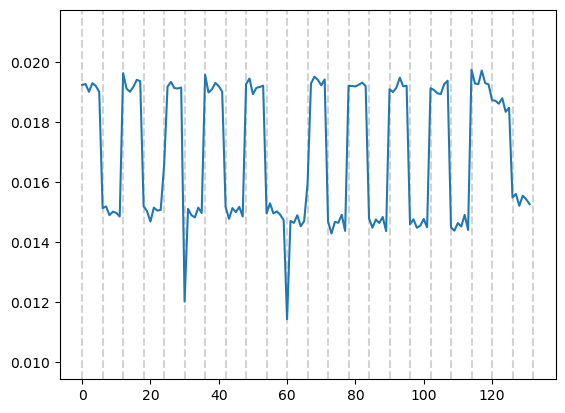

In [24]:
padding = 0.002
plt.vlines(experiment_start_points,min(all_back_emf)-padding,max(all_back_emf)+padding,color='lightgrey',linestyle='--')
plt.plot(all_back_emf)
plt.ylim(min(all_back_emf)-padding,max(all_back_emf)+padding)
print(f"Mean: {np.mean(all_back_emf)}, Standard Deviation: {np.std(all_back_emf)}")